# This notebook is for the Fair-Shapely experiment

In [1]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [3]:
from src.data.unified_dataloader import load_dataset

a, processed_compas = load_dataset('compas')

In [4]:
processed_compas.head(3)

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,2.875313,-0.141855,-0.187414,-0.218065,-0.711240,0,0,0,0,0,1,1,0,1,0,1,0,0
1,1,-0.068808,-0.141855,-0.187414,-0.218065,-0.711240,1,0,0,0,0,0,1,0,1,0,1,0,1
2,1,-0.909985,-0.141855,-0.187414,1.775750,0.108063,1,0,0,0,0,0,1,0,1,0,1,0,1


### 3. Split label/unlabel data, split train/test data.

In [5]:
'''COMPAS'''
df = processed_compas.copy()
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (5049, 18)
X_test shape: (2165, 18)


### 4. Train the original model

In [6]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6609699769053118


In [7]:
X_train['sex'].value_counts()

sex
1    4060
0     989
Name: count, dtype: int64

In [8]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 1
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 0
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [9]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_DR: {original_DR}')

c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


original_DR: 0.09081892669200897


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

3. 将X_train_minority与X_train_replace_majority进行匹配
4. 使用fairshap,把X_train_minority作为baseline dataset，找到X_train_replace_majority中需要替换的数据
未处理前非0值的个数:477


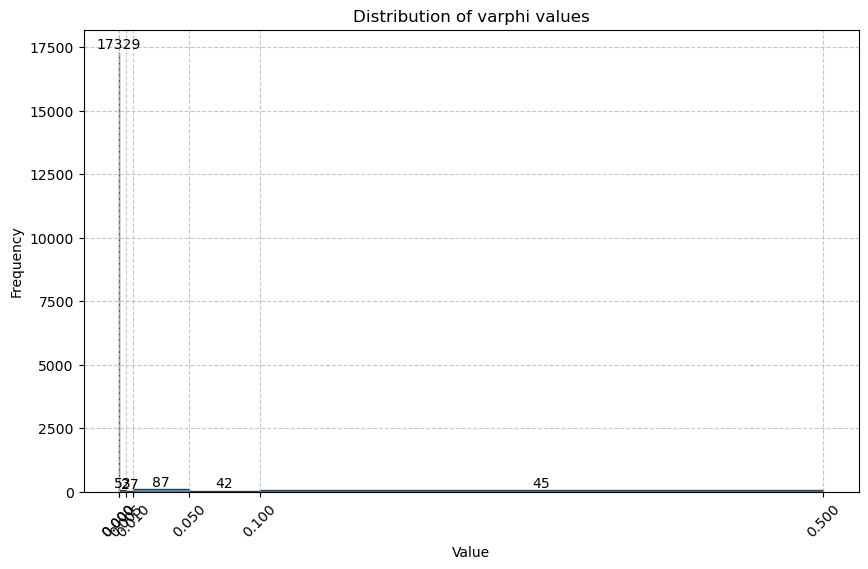

shapley value 大于0.1的值的个数:45


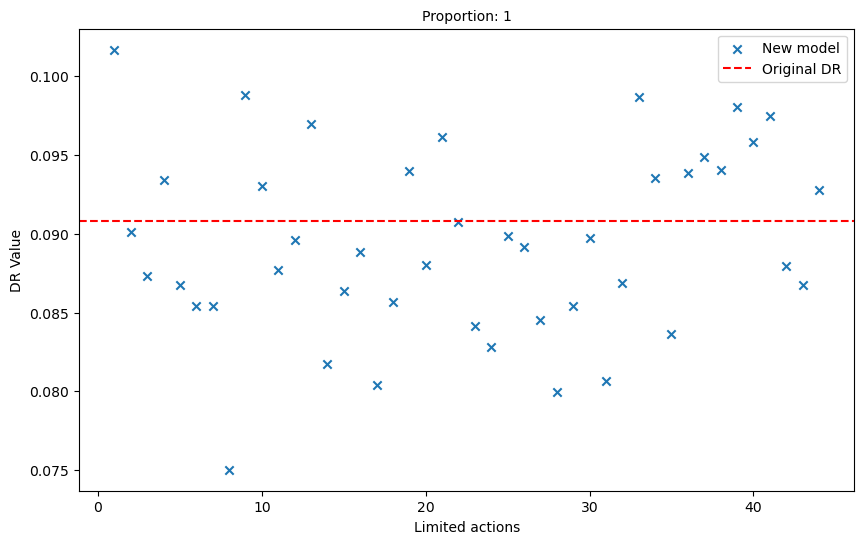

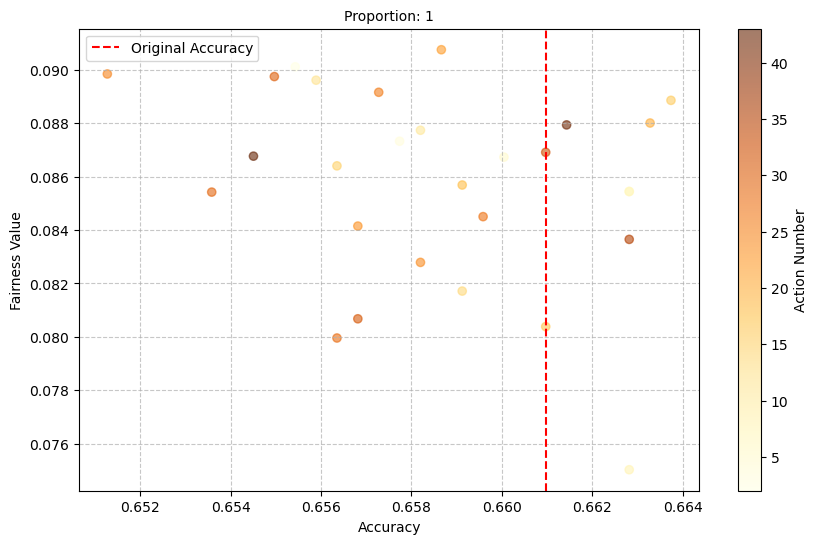

([0.10167785,
  0.09010654,
  0.08732267,
  0.09339526,
  0.08672584,
  0.08544022,
  0.08544022,
  0.07502907,
  0.098834954,
  0.09302644,
  0.08773211,
  0.08960571,
  0.09693866,
  0.0817143,
  0.086399764,
  0.08885139,
  0.08038467,
  0.085683025,
  0.09398144,
  0.088003516,
  0.096157566,
  0.090745516,
  0.08414677,
  0.08278777,
  0.08983821,
  0.08915295,
  0.08449961,
  0.07995814,
  0.08541764,
  0.08974078,
  0.080676556,
  0.08690615,
  0.09868141,
  0.093518674,
  0.08364885,
  0.09383503,
  0.094858795,
  0.09402,
  0.0980333,
  0.095846914,
  0.097450346,
  0.087932035,
  0.08676291,
  0.09279231],
 [(0.09010654, 0.6554272517321016, 2),
  (0.08732267, 0.6577367205542726, 3),
  (0.08672584, 0.6600461893764434, 5),
  (0.08544022, 0.6628175519630485, 6),
  (0.08544022, 0.6628175519630485, 7),
  (0.07502907, 0.6628175519630485, 8),
  (0.08773211, 0.6581986143187067, 11),
  (0.08960571, 0.6558891454965358, 12),
  (0.0817143, 0.6591224018475751, 14),
  (0.086399764, 0.65635

In [10]:
from src.experiments_approach2 import ExperimentNew

''' 改变minority group中的部分特征值'''

experiment = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas',
                            change_group = 'minority')
experiment.run_experiment()


3. 将X_train_minority与X_train_replace_majority进行匹配
4. 使用fairshap,把X_train_replace_majority作为baseline dataset，找到X_train_minority中需要替换的数据
未处理前非0值的个数:5176


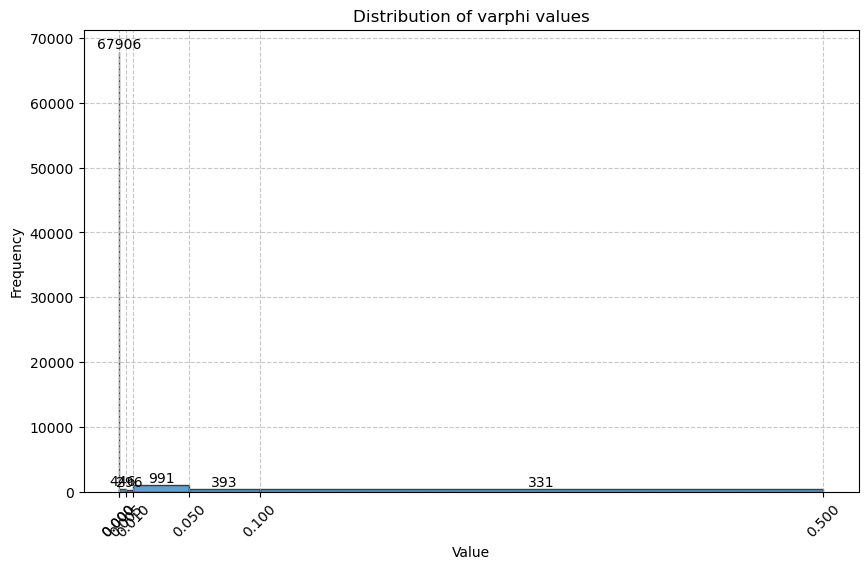

shapley value 大于0.1的值的个数:333


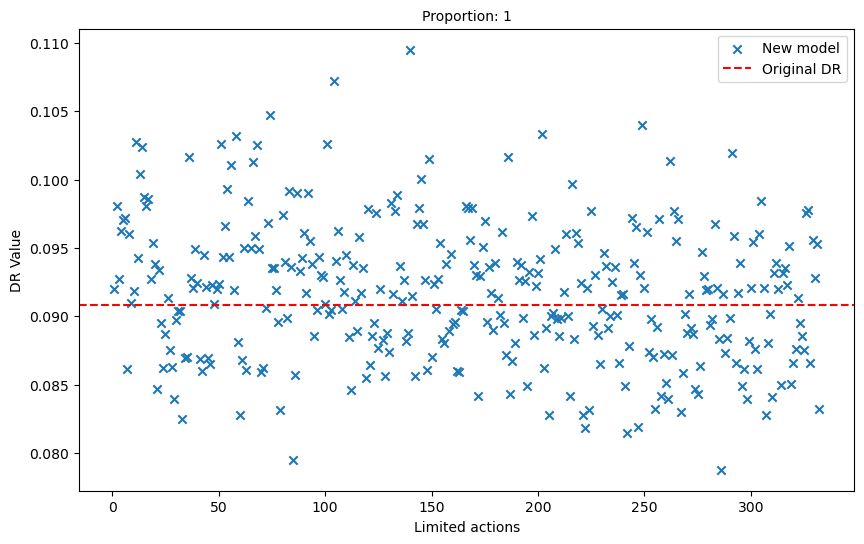

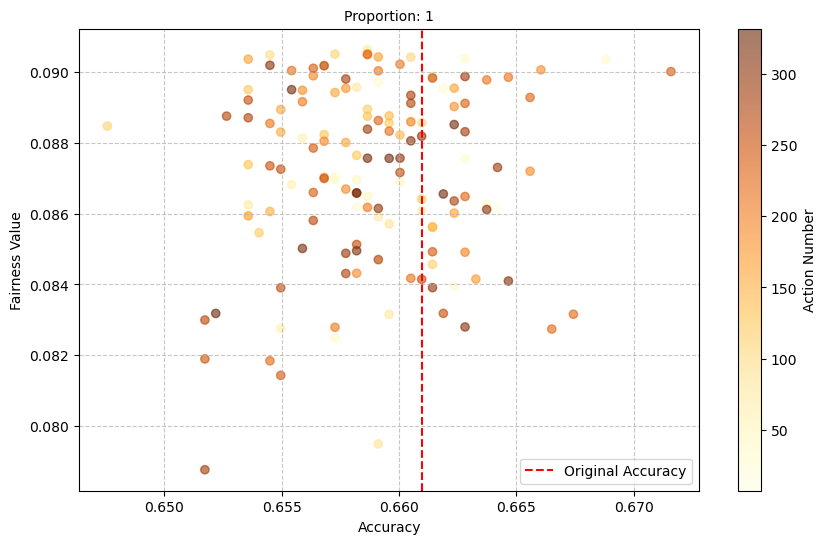

([0.0919552,
  0.09803021,
  0.09275308,
  0.09626125,
  0.09704914,
  0.09717485,
  0.08614526,
  0.09601932,
  0.0909362,
  0.09183298,
  0.10272665,
  0.0942654,
  0.10038517,
  0.10240781,
  0.09871123,
  0.09805129,
  0.09857718,
  0.0926966,
  0.09537992,
  0.0937886,
  0.08466725,
  0.09340182,
  0.08952834,
  0.08619875,
  0.08868375,
  0.09134676,
  0.087540075,
  0.086269714,
  0.08395174,
  0.0897108,
  0.09035409,
  0.09037873,
  0.08248718,
  0.08695215,
  0.08702387,
  0.10166347,
  0.09282097,
  0.09207111,
  0.09491326,
  0.09241061,
  0.08688648,
  0.08596991,
  0.09451215,
  0.09215482,
  0.08695494,
  0.08649243,
  0.09229135,
  0.09085876,
  0.09199378,
  0.092356905,
  0.10257745,
  0.09435996,
  0.096612915,
  0.09930718,
  0.09433199,
  0.101059586,
  0.091885805,
  0.10315849,
  0.08813172,
  0.082754515,
  0.08681897,
  0.095023446,
  0.08608559,
  0.09845355,
  0.09500809,
  0.10127427,
  0.09583654,
  0.10255991,
  0.09491336,
  0.085906036,
  0.08624541,
  0

In [11]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas',
                            change_group = 'majority')
experiment2.run_experiment()